# Processing of SCIP features

SCIP features have been computed on EhV data form the first large scale experiment, on files: H1_T7, H1_T8, H1_T9, H2_T7, H2_T8, H2_T9

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from umap import UMAP
import time
import math
import tifffile
import pyarrow.parquet as pq
import pyarrow
# from ehv import masking

## SCIP computed features

In [4]:
import os
os.environ["VSC_DATA_VO_USER"]

'/data/gent/vo/000/gvo00070/vsc42015'

In [5]:
df = pandas.concat([
    pq.read_table(p).to_pandas()
    for p in Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201311209_skitty/").glob("*.parquet")
], axis=0)

In [6]:
df.shape

(142451, 1294)

In [7]:
df["meta_sample"] = df["meta_path"].apply(lambda p: Path(p).stem)

In [8]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

pop_dir = "/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/meta/pop"
pop_files = list(Path(pop_dir).glob("*.pop"))
pops = {}
for sample in df["meta_sample"].unique():
    pops[sample] = {}
    
    for f in pop_files:
        if f.name.startswith(sample):
            pop_file = f
            with open(pop_file, "r") as fh:
                content = fh.read()
                if len(content) > 0:
                    indices = content[:-2].replace("\n", "").replace(" ", "").strip().split(",")
                    for idx in indices:
                        pops[sample][int(idx)] = pop_file.stem[find_nth(pop_file.stem, "_", 4)+1:]

In [9]:
def map_to_class(x):
    try:
        return pops[x.meta_sample][x.meta_object_number]
    except KeyError:
        return "unknown"

In [10]:
%%time
df["meta_label"] = "unknown"
chunk_size = len(df)//10 + 1
for i in range(0, 10):
    df.iloc[i*chunk_size:(i+1)*chunk_size, df.columns.get_loc("meta_label")] = df.iloc[i*chunk_size:(i+1)*chunk_size].apply(map_to_class, axis=1)
    print(i)

0
1
2
3
4
5
6
7
8
9
CPU times: user 7.7 s, sys: 3.6 s, total: 11.3 s
Wall time: 11.3 s


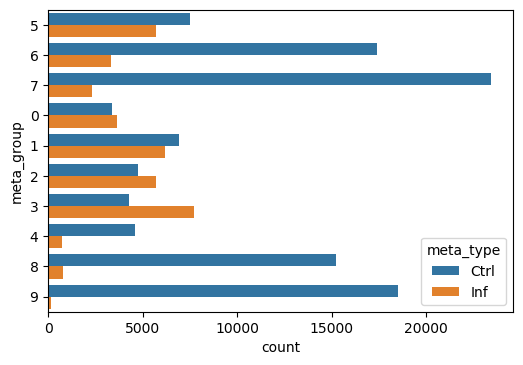

In [11]:
fig, ax = plt.subplots(dpi=100)
seaborn.countplot(ax=ax, data=df, y="meta_group", hue="meta_type")

In [12]:
df[df["meta_type"] == "Inf"]["meta_label"].value_counts()

mcp-_psba+    15664
mcp+_psba-     8359
mcp+_psba+     5320
mcp-_psba-     3831
unknown        3184
Name: meta_label, dtype: int64

In [13]:
df.shape

(142451, 1296)

In [14]:
df = df.reset_index(drop=True)

In [15]:
pq.write_table(pyarrow.Table.from_pandas(df), "/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202201311209_skitty/features.parquet")